In [1]:
!tree input

폴더 PATH의 목록입니다.
볼륨 일련 번호는 26D8-C7D0입니다.
C:\USERS\JINSOO\PYCHARMPROJECTS\KAGGLE\DENOISING_DIRTY_DOCUMENTS\INPUT
├─test
├─train
└─train_cleaned


In [1]:
import glob
train_images = glob.glob('./data/denoising-dirty-documents/train/*.png')
train_labels = glob.glob('./data/denoising-dirty-documents/train_cleaned/*.png')
test_images = glob.glob('./input/test/*.png')

print('Train_images : {}'.format(len(train_images)))
print('Train_labels : {}'.format(len(train_labels)))
print('Test_images : {}'.format(len(test_images)))

Train_images : 144
Train_labels : 144
Test_images : 0


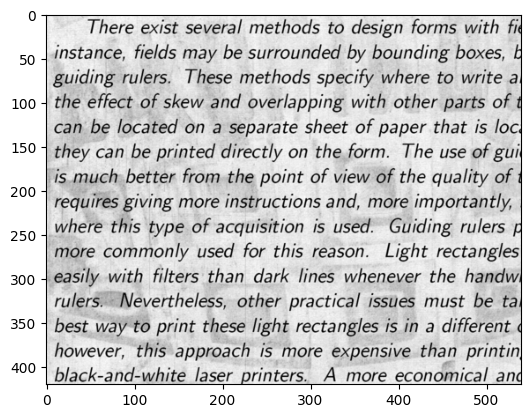

(420, 540)


In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img = cv2.imread(train_images[0], 0)
plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)

In [4]:
import numpy as np
# data read
X = []
Y = []
for images_path, labels_path in zip(train_images, train_labels):
    img = cv2.imread(images_path, 0)
    img = cv2.resize(img, (540, 420))
    lab = cv2.imread(labels_path, 0)
    lab = cv2.resize(lab, (540, 420))
    X.append(img)
    Y.append(lab)
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((144, 420, 540), (144, 420, 540))

In [5]:

# # save augmented data (only first)
# def save_aug(X, Y, file_name):
#     for i, (x, y) in enumerate(zip(X, Y)):
#         im = Image.fromarray(x)
#         im.save('./input/train/{}{}.png'.format(file_name, i))
#         im = Image.fromarray(y)
#         im.save('./input/train_cleaned/{}{}.png'.format(file_name, i))

# # augmented image maker for X and Y image
# def aug_hflip(X, Y, p):
#     aug_X = []
#     aug_Y = []
#     for x,y in zip(X, Y):
#         if p > np.random.rand():
#             aug_X.append(np.fliplr(x))
#             aug_Y.append(np.fliplr(y))
#     aug_X = np.array(aug_X)
#     aug_Y = np.array(aug_Y)
#     save_aug(aug_X, aug_Y, 'aug_hflip')

# def aug_vflip(X, Y, p):
#     aug_X = []
#     aug_Y = []
#     for x,y in zip(X, Y):
#         if p > np.random.rand():
#             aug_X.append(np.flipud(x))
#             aug_Y.append(np.flipud(y))
#     aug_X = np.array(aug_X)
#     aug_Y = np.array(aug_Y)
#     save_aug(aug_X, aug_Y, 'aug_vflip')
    
# # Augmentation
# aug_hflip(X, Y, p=0.6)
# aug_vflip(X, Y, p=0.6)

In [7]:
# Augmented data check
train_images = glob.glob('./data/denoising-dirty-documents/train/*.png')
train_labels = glob.glob('./data/denoising-dirty-documents/train_cleaned/*.png')
test_images = glob.glob('./input/test/*.png')

print('Train_images : {}'.format(len(train_images)))
print('Train_labels : {}'.format(len(train_labels)))
print('Test_images : {}'.format(len(test_images)))

Train_images : 144
Train_labels : 144
Test_images : 0


In [8]:
# data reload
X = []
Y = []
for images_path, labels_path in zip(train_images, train_labels):
    img = cv2.imread(images_path, 0)
    img = cv2.resize(img, (540, 420))
    lab = cv2.imread(labels_path, 0)
    lab = cv2.resize(lab, (540, 420))
    X.append(img)
    Y.append(lab)
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((144, 420, 540), (144, 420, 540))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=4)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((140, 420, 540), (4, 420, 540), (140, 420, 540), (4, 420, 540))

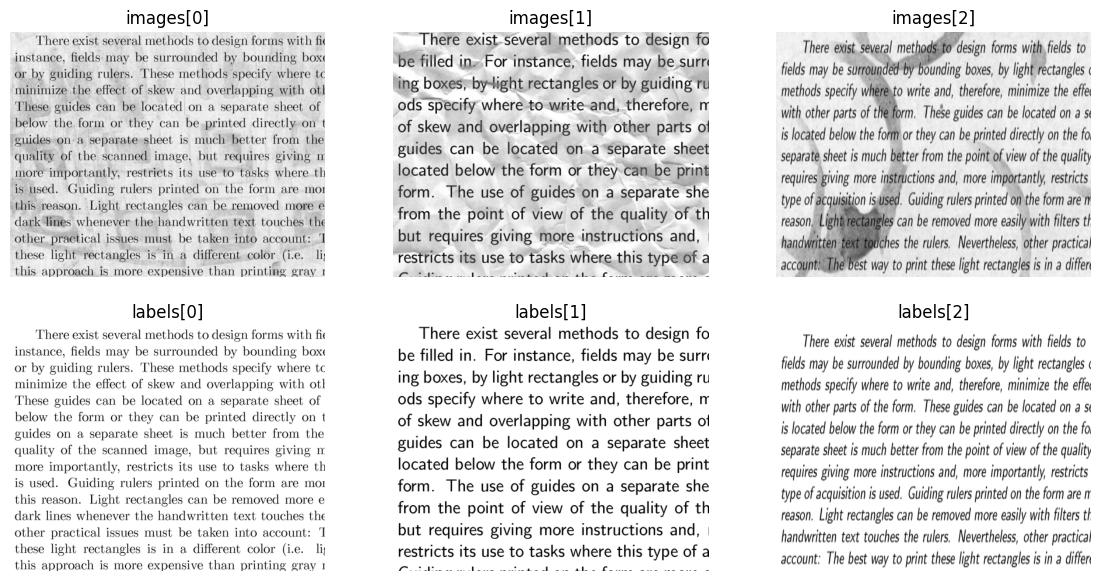

In [10]:
# images, labels show
fig, ax = plt.subplots(2, 3, figsize=(14,7))
for i, (x,y) in enumerate(zip(X_train[:3],Y_train[:3])):
    ax[0, i%3].imshow(x, cmap='gray')
    ax[0, i%3].set_title('images[{}]'.format(i))
    ax[0, i%3].axis('off')
    ax[1, i%3].imshow(y, cmap='gray')
    ax[1, i%3].set_title('labels[{}]'.format(i))
    ax[1, i%3].axis('off')
plt.show()

In [11]:
X_train = X_train.reshape((len(X_train), 1, 420, 540))
X_valid = X_valid.reshape((len(X_valid), 1, 420, 540))
Y_train = Y_train.reshape((len(Y_train), 1, 420, 540))
Y_valid = Y_valid.reshape((len(Y_valid), 1, 420, 540))

In [12]:
import torch
# train set
X_train = torch.from_numpy(X_train).type(torch.FloatTensor) / 255.
Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor) / 255.
# valid set
X_valid = torch.from_numpy(X_valid).type(torch.FloatTensor) / 255.
Y_valid = torch.from_numpy(Y_valid).type(torch.FloatTensor) / 255.

In [13]:
from torch.utils.data import DataLoader, TensorDataset
# images & labels set
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)
# data loader
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [14]:
import torch.nn as nn


class simple_CAE(nn.Module):
    def __init__(self):
        super(simple_CAE, self).__init__()
        self.nf = 64
        self.model = nn.Sequential(
            nn.Conv2d(1, self.nf, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.nf, self.nf*2, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            
            nn.ConvTranspose2d(self.nf*2, self.nf*2, 2, 2, 0, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.nf*2, self.nf, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.nf, self.nf, 2, 2, 0, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.nf, 1, 3, 1, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(1, 1, 3, 1, 1, bias=False),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        x = self.model(x).view(-1, 1, 420, 540)
        return x

In [16]:
# Model to cuda
Net = simple_CAE().cpu()
print(Net)

simple_CAE(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): Sigmoid()
  )
)


In [17]:
from torch.optim import Adam
# Optimizer
lr = 1e-03
criterion = nn.BCELoss()
optimizer = Adam(Net.parameters(), lr=lr)

KeyboardInterrupt: 

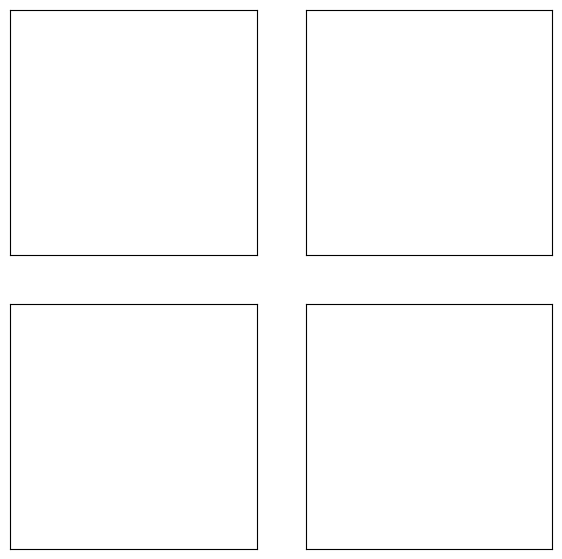

In [19]:
from torch.autograd import Variable
from IPython import display
import time
import itertools
# image plot frame
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
for i,j in itertools.product(range(ax.shape[0]), range(ax.shape[1])):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Train start
epochs = 30
loss_total = []
start_time = time.time()

for epoch in range(epochs):
    for n, (image, label) in enumerate(train_loader):
        image, label = Variable(image.cpu()), Variable(label.cpu())
        optimizer.zero_grad()
        output = Net(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        loss_total.append(loss.item())
        
    # valid per 10 epoch 
    if epoch == 0 or (epoch+1) % 10 == 0:
        valid_image = X_valid[:4]
        valid_image = Net(Variable(valid_image.reshape(4, 1, 420, 540).cpu()))
        for i in range(4):
            y = i // 2
            x = i % 2
            ax[x,y].cla()
            ax[x,y].imshow(valid_image[i,0].data.cpu().numpy(), cmap='gray')
        plt.savefig('./simple_CAE_{:d}.png'.format(epoch+1))
        print('Epoch [{:d}/{:d}], loss = {:0.2f}'.format(epoch+1, epochs, loss))
        if epoch != epochs-1:
            display.display(plt.gcf())

end_time = time.time()

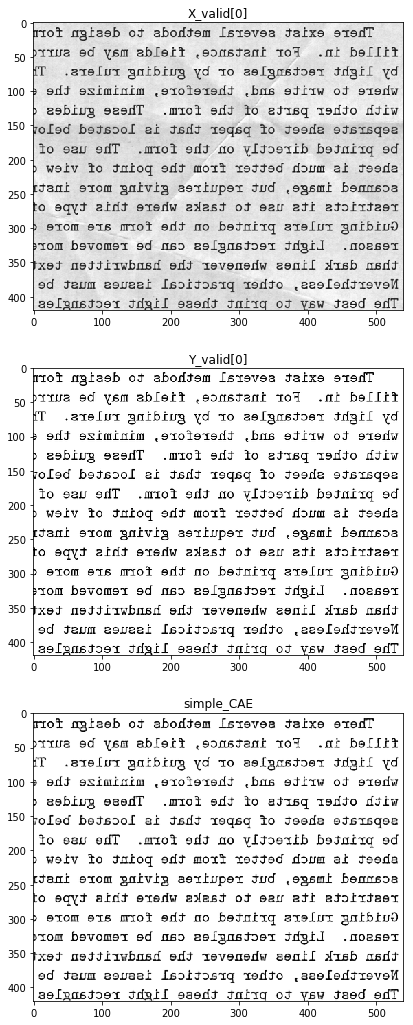

In [17]:
# for valid image[0] comparision
image = Net(Variable(X_valid[0].reshape(1, 1, 420, 540).cuda()))
image = image.data.cpu().numpy().reshape(420, 540)
image = image.clip(0, 1)
%matplotlib inline
plt.figure(figsize=(14, 18))
plt.subplot(3,1,1)
plt.title('X_valid[0]')
plt.imshow(X_valid[0].reshape(420, 540), cmap='gray')
plt.subplot(3,1,2)
plt.title('Y_valid[0]')
plt.imshow(Y_valid[0].reshape(420, 540), cmap='gray')
plt.subplot(3,1,3)
plt.title('simple_CAE')
plt.imshow(image, cmap='gray')

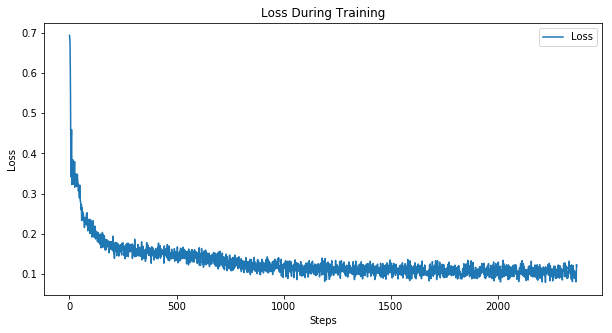

Elapsed Time = 397.43 sec


In [18]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(loss_total,label="Loss")
plt.xlabel("Steps") # Steps = 316(train data) / 4(batch) * 30(epoch) = 2370
plt.ylabel("Loss")
plt.legend()
plt.show()

elapsed_time = end_time - start_time
print('Elapsed Time = {:.2f} sec'.format(elapsed_time))

In [19]:
torch.save(Net.state_dict(), './saved_simple_CAE.pt')

In [20]:
# test
ids = []
values = []

for image_path in test_images:
    img = cv2.imread(image_path, 0)
    img_shape = img.shape
    img = cv2.resize(img, (540, 420))
    img = img.reshape(1, 1, 420, 540)
    # test_img predict
    test_img = torch.from_numpy(img).type(torch.FloatTensor) / 255.
    pred = Net(Variable(test_img.cuda()))
    pred = pred.data.cpu().numpy().reshape(420, 540)
    if img_shape[1] == 258:
        pred = cv2.resize(pred, (540, img_shape1))
    image_name = image_path.split('\\')[1][:-4]
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            ids.append('{}_{}_{}'.format(image_name, i+1, j+1))
            values.append(pred[i,j])
    print('image file No.{} end'.format(image_name))

image file No.1 end
image file No.10 end
image file No.100 end
image file No.103 end
image file No.106 end
image file No.109 end
image file No.112 end
image file No.115 end
image file No.118 end
image file No.121 end
image file No.124 end
image file No.127 end
image file No.13 end
image file No.130 end
image file No.133 end
image file No.136 end
image file No.139 end
image file No.142 end
image file No.145 end
image file No.148 end
image file No.151 end
image file No.154 end
image file No.157 end
image file No.16 end
image file No.160 end
image file No.163 end
image file No.166 end
image file No.169 end
image file No.172 end
image file No.175 end
image file No.178 end
image file No.181 end
image file No.184 end
image file No.187 end
image file No.19 end
image file No.190 end
image file No.193 end
image file No.196 end
image file No.199 end
image file No.202 end
image file No.205 end
image file No.208 end
image file No.211 end
image file No.214 end
image file No.22 end
image file No.25 

In [21]:
import pandas as pd
# submit            
submissions = pd.DataFrame({'id': ids, 'value': values})
submissions.to_csv('submission.csv', index=False, header=True)
# check
print(submissions[:10])

       id     value
0   1_1_1  0.994513
1   1_1_2  0.998040
2   1_1_3  0.997967
3   1_1_4  0.998473
4   1_1_5  0.998428
5   1_1_6  0.997854
6   1_1_7  0.997671
7   1_1_8  0.997858
8   1_1_9  0.997897
9  1_1_10  0.997663
